In [1]:
from ipyparallel import Client
rc = Client()
lview = rc.load_balanced_view()

In [2]:
import holoviews as hv
%reload_ext holoviews.ipython

# interactive definitions

In [3]:
%%px --local
from time import sleep

def f(x):
    sleep(1)
    return x+2

In [4]:
map(f, range(5))

[2, 3, 4, 5, 6]

In [5]:
async = lview.map_async(f, range(5))
async.wait_interactive()
async.get()

   5/5 tasks finished after    1 s
done


[2, 3, 4, 5, 6]

# developing simulating with kwant

Tutorial 2.2.3 from [Kwant webpage](http://kwant-project.org/doc/1.0/tutorial/tutorial1#building-the-same-system-with-less-code) (skipping comments)

In [6]:
%%px --local

import kwant
import numpy as np
def make_system(a=1, t=1.0, W=10, L=30):
    lat = kwant.lattice.square(a)
    sys = kwant.Builder()

    sys[(lat(x, y) for x in range(L) for y in range(W))] = 4 * t
    sys[lat.neighbors()] = -t

    lead = kwant.Builder(kwant.TranslationalSymmetry((-a, 0)))
    lead[(lat(0, j) for j in xrange(W))] = 4 * t
    lead[lat.neighbors()] = -t

    sys.attach_lead(lead)
    sys.attach_lead(lead.reversed())

    return sys

## creating system

In [7]:
%%px --local
sys = make_system()
sys = sys.finalized()

## calculating conductance

In [8]:
def get_conductance(energy):
    smatrix = kwant.smatrix(sys, energy)
    return smatrix.transmission(1, 0)

In [9]:
energies = np.linspace(0, 2, 50)
async = lview.map_async(get_conductance, energies)
G = np.array(async.get())

:Path   [x,y]
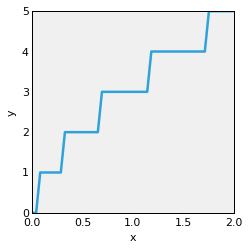

In [10]:
%opts Path [aspect='square'] 
hv.Path((energies, G))